In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import cv2
import imageio
import os
from tqdm import tqdm
import gc
import random
import shutil
from keras import layers
import numpy as np
from keras.applications import EfficientNetB0
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
data_path = '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer'
directories = []
for directory in os.listdir(data_path):
    directories.append(directory)
print('Classes Present : ',list(directories))

Classes Present :  ['colon_bnt', 'colon_aca', 'lung_aca', 'lung_bnt', 'lung_scc']


In [2]:
source_path = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer"
destination_path = "/kaggle/working/Lung_Cancer_Only"

shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

unwanted_dirs = ['colon_bnt', 'colon_aca']
for dir_name in unwanted_dirs:
    dir_path = os.path.join(destination_path, dir_name)
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        
directories = os.listdir(destination_path)
print('Remaining Classes:', directories)

Removed: colon_bnt
Removed: colon_aca
Remaining Classes: ['lung_aca', 'lung_bnt', 'lung_scc']


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = "/kaggle/working/Lung_Cancer_Only"

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

NUM_CLASSES = len(ds_train.class_names)
print("Classes:", ds_train.class_names)


Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Classes: ['lung_aca', 'lung_bnt', 'lung_scc']


In [4]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.1),
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(factor=0.2),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_train(image, label):
    image = img_augmentation(image)
    image = tf.cast(image, tf.float32) / 255.0  
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def preprocess_test(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = ds_train.map(preprocess_train, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess_test, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.prefetch(AUTOTUNE)


In [6]:
for image_batch, label_batch in ds_train.take(1):
    print("Image batch shape:", image_batch.shape)  
    print("Label batch shape:", label_batch.shape) 

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


In [7]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

epochs = 30
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization_1[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)             

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 161s 232ms/step - accuracy: 0.7548 - loss: 1.0131 - val_accuracy: 0.3457 - val_loss: 12.8681
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - accuracy: 0.9084 - loss: 0.2394 - val_accuracy: 0.6580 - val_loss: 1.2539
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 200ms/step - accuracy: 0.9238 - loss: 0.1958 - val_accuracy: 0.3330 - val_loss: 60091.4297
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 199ms/step - accuracy: 0.9088 - loss: 0.2416 - val_accuracy: 0.9617 - val_loss: 0.1058
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - accuracy: 0.9440 - loss: 0.1488 - val_accuracy: 0.9493 - val_loss: 0.1343
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - accuracy: 0.9509 - loss: 0.1140 - val_accuracy: 0.9727 - val_loss: 0.0820
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 195ms/step - accuracy: 0.9542 - loss: 0.1128 - val_accuracy: 0.9563 - val_loss: 0.1126
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 199ms/step - accuracy: 0.9696 - l

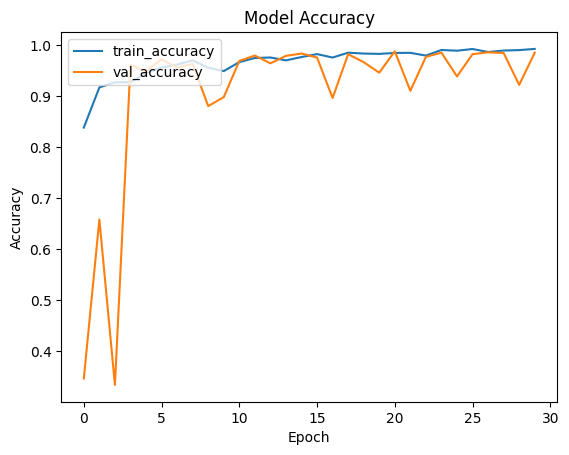

In [16]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"], label="train_accuracy")
    plt.plot(hist.history["val_accuracy"], label="val_accuracy")
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")
    plt.show()

plot_hist(hist)

In [8]:
model.save("EffNet_lung_cancer.h5") 

In [2]:
loaded_model = tf.keras.models.load_model("/kaggle/input/efficientnet/keras/default/1/EffNet_lung_cancer.h5")
image_path = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer/lung_bnt/lung_bnt_0007.jpg"  
img = image.load_img(image_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array / 255.0 
prediction = loaded_model.predict(img_array)
predicted_class = np.argmax(prediction)

class_labels = ["Lung Adenocarcinoma", "Lung Benign", "Lung Squamous Cell Carcinoma"] 

print("Predicted Class:", class_labels[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Lung Benign
